In [31]:
#allows any changes on external files to be loaded on code run.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generating Data on LUMI

In [4]:
# from GENE_ML.gene_ml.samplers.uniform import Uniform
# from GENE_ML.gene_ml.executors.ScanExecutor import ScanExecutor
# from GENE_ML.gene_ml.runners.GENErunner import GENErunner
# from GENE_ML.gene_ml.parsers.GENEparser import GENE_scan_parser

# import os
# import sys
# sys.path.append(os.path.join(os.getcwd(),'GENE_ML','enchanted-surrogates','src'))

# parameters = ['_grp_species_1-omt', '_grp_species_0-omt']
# bounds = [(4,6.7), (2.1,3.5)] #if bounds is a float rather than tuple then the sampler will make that the only value

# #Working fine
# # parameters = ['box-kymin', '_grp_species_1-omt', 'species-omn']
# # bounds = [(0.05,1), (10,70), (5,60)]

# num_samples = 5
# sampler = Uniform(parameters=parameters, bounds=bounds, num_samples=num_samples)

# ##Parser
# #The parsers main function is write_input_file
# # wite_input_file takes a parameters file from base_params_path and a set of points in the form of a dict {param1:[point1,point2...], param2:[point1,point2...]...} 
# #  It will then create a parameters file that can scan over all the points.
# base_params_path = os.path.join(os.getcwd(),'parameters_base_uq')
# remote_save_dir='/scratch/project_462000451/gene_out/gene_auto/test'
# save_dir = "/temp"
# parser = GENE_scan_parser(save_dir, base_params_path, remote_save_dir)

# ## Runner
# #The Runner is responsible for actually running a parameters file on lumi. Its main function is code_run.
# # code_run will take the set of points named samples and parse them into a parameters file.
# #  It then uses ssh to run GENE with this parametres file and a passed sbatch script.
# host = 'lumi' #needs to be configured in /home/<user>/.ssh/config
# sbatch_base_path = os.path.join('sbatch_base')
# guess_sample_wallseconds = 81 # a guess for the number of seconds it takes to run one sample.
# remote_run_dir = '/project/project_462000451/gene/'
# runner = GENErunner(parser, host, sbatch_base_path, guess_sample_wallseconds, remote_run_dir)

# ##Executor
# #The executor will divide the samples into batches; one for each worker. Each batch will be ran in paralell in seperate sbatch jobs. 
# # The executor should alter a base batch script to account for that less samples will be ran. 
# num_workers = 1
# executor = ScanExecutor(num_workers, sampler, runner, remote_save_dir=remote_save_dir)


#########################


import sys
import os
pathap = os.path.join('GENE_ML','gene_ml','static_sparse_grid_approximations')
print('PATHAP',pathap)
sys.path.append(pathap)
from GENE_ML.gene_ml.samplers.LatinHyperCube import LatinHyperCube
from GENE_ML.gene_ml.datagen.datagen import DataGen
from config import Config
config = Config()

num_samples = 2000
parameters = ['_grp_species_0-omt','_grp_species_1-omt','species-omn']
bounds = [(4,6.7), (2.1,3.5), (0.16,2.9)] #if bounds is a float rather than tuple then the sampler will make that the only value
nominal = [2.7954880, 5.3871083, 1.5417906]
sampler_lhc = LatinHyperCube(parameters=parameters, num_samples=num_samples ,bounds=bounds)


remote_save_name = "UQ-DEMO-highprec-lhc-2000"
datagen_lhc = DataGen(config, sampler_lhc, num_workers=8, remote_save_name=remote_save_name, ex_id=remote_save_name, single_run_timelim=40, single_run_simtimelim=26000)

PATHAP GENE_ML/gene_ml/static_sparse_grid_approximations
<class 'paramiko.sftp_file.SFTPFile'>


In [5]:
datagen_lhc.executor.pre_run_check()


EXECUTOR, PRINT_CHECK_PARAMETERS
 ----------------------------------------------------------------------------------------------------
PRE RUN CHECK


SINGLE RUN TIMELIM 40 N SAMPLES 250
THE ESTIMATED WALLTIME FOR RUN ex-UQ-DEMO-highprec-lhc-2000_batch-0 is 00-03:03:20, dd-hh-mm-ss TO RUN 250 SAMPLES
CHECKING IF PROBLEM DIRECTORY EXISTS?
REMOTE PROBLEM DIRECTORY DOES NOT EXIST, CREATING IT NOW: /project/project_462000451/gene/auto_prob_ex-UQ-DEMO-highprec-lhc-2000_batch-0
RESULT FROM COMMAND: b'set lib path in ./tools/scanscript\nset lib path in ./tools/scanscript\ncreated prob01\ncopied parameters\ncreated link to the GENE executable in the bin directory\n'
PLACING BASE PARAMETERS AND SBATCH TO REMOTE PROBLEM DIRECTORY
ALTERING THE PARAMETERS FILE IN THE REMOTE PROBLEM DIRECTORY
43 timelim 40
    timelim = 33200

    timelim = 40



CODE RUN: SETTING SIMULATION TIME LIMMIT


45 simtimelim 26000
    simtimelim = 26000

    simtimelim = 26000

SBATCH
WRITE SBATCH
#!/bin/bash -l
## LUMI

In [6]:
datagen_lhc.executor.start_runs()

EXECUTING BATCHES
PRE RUN CHECK


SINGLE RUN TIMELIM 40 N SAMPLES 250
THE ESTIMATED WALLTIME FOR RUN ex-UQ-DEMO-highprec-lhc-2000_batch-0 is 00-03:03:20, dd-hh-mm-ss TO RUN 250 SAMPLES
CHECKING IF PROBLEM DIRECTORY EXISTS?
PLACING BASE PARAMETERS AND SBATCH TO REMOTE PROBLEM DIRECTORY
ALTERING THE PARAMETERS FILE IN THE REMOTE PROBLEM DIRECTORY
43 timelim 40
    timelim = 33200

    timelim = 40



CODE RUN: SETTING SIMULATION TIME LIMMIT


45 simtimelim 26000
    simtimelim = 26000

    simtimelim = 26000

SBATCH
WRITE SBATCH
#!/bin/bash -l
## LUMI-C (CPU partition) submit script template
## Submit via: sbatch submit.cmd (parameters below can be overwritten by command line options)
#SBATCH -t 00-03:03:20  ## wallclock limit, dd-hh:mm:ss
#SBATCH -N 2                       # total number of nodes, 2 CPUs with 64 rank each
#SBATCH --ntasks-per-node=128      # 64 per CPU. Additional 2 hyperthreads disabled
#SBATCH --mem=0                    # Allocate all the memory on each node
#SBATCH -

# Pulling Data from LUMI

The data loaded was created by scanning over ion and electron temperature gradients within their margin of uncertainty. 

In [3]:
from GENE_ML.gene_ml.dataset.ScanData import ScanData
from GENE_ML.gene_ml.parsers.GENEparser import GENE_scan_parser
from config import Config
config = Config()
parser = GENE_scan_parser(config)
data_name = '200s_3p_uq-highprec_old'
test_percentage=50
# local_save_dir = '/home/djdaniel/GENE_UQ/scanlogs/200s_3p_uq-highprec_old'
# data_set_uniform = ScanData(data_name, datagen_uniform.parser, config.host, remote_save_dir=datagen_uniform.remote_save_dir, test_percentage=test_percentage)
data_set_uniform = ScanData(data_name, parser, config.host, remote_save_dir=None, test_percentage=test_percentage)

/home/djdaniel/anaconda3/envs/gene_ml/lib/python3.12/site-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/home/djdaniel/anaconda3/envs/gene_ml/lib/python3.12/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
/home/djdaniel/anaconda3/envs/gene_ml/lib/python3.12/site-packages/paramiko/transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


<class 'paramiko.sftp_file.SFTPFile'>
Initialising dataset
SSH PATH None:None
SCAN LOG PATH /home/djdaniel/GENE_UQ/scanlogs/200s_3p_uq-highprec_old

LOADING FROM SCANLOG DIR: /home/djdaniel/GENE_UQ/scanlogs/200s_3p_uq-highprec_old
LOG PATHS ['scan_batch-0_0.log' 'scan_batch-1_0.log']

LOADING SCANLOG AND TIME INTO PANDAS DATAFRAME /home/djdaniel/GENE_UQ/scanlogs/200s_3p_uq-highprec_old/scan_batch-0_0.log : None

LOADING SCANLOG AND TIME INTO PANDAS DATAFRAME /home/djdaniel/GENE_UQ/scanlogs/200s_3p_uq-highprec_old/scan_batch-1_0.log : None

200 SAMPLES RAN OUT OF 200 BEFORE MAX WALLTIME:
NUMBER OF SAMPLES AFTER REMOVING NaN's: 200
NaN PERCENTAGE =  0.0
SETTING VARIABLES

RANDOMLY SPLITTING DATA INTO TEST AND TRAINING SETS: 50% test, 50 training.


In [15]:
import numpy as np
print(np.any(data_set_uniform.df['growthrate']))

print(data_set_uniform.x_train[0])

True
[2.518653 5.100391 1.474128]


# Training Surrogate Model 

In [4]:
import os
from GENE_ML.gene_ml.models.GPR import GPR
from GENE_ML.gene_ml.results.results import Results

#numsamples_numparameters_model_testpercentage
model_name = 'GPR'
results_gpr_name = 'UQ-DEMO_results_100s_3p_GPR_50tp'
#results_gpr_name = f'uq_results_{num_samples}s_{len(parameters)}p_{model_name}_{test_percentage}tp' #
results_gpr = Results(results_gpr_name)
gpr = GPR(name = model_name, dim=3)
if os.path.exists(results_gpr.path) and os.path.exists(gpr.path):
    print('\nLOADING RESULTS FROM FILE\n')
    results_gpr = results_gpr.load()
    print(f'{results_gpr.name} IS LOADED')
    gpr = gpr.load()
else:
    print('\nCOMPUTING RESULTS\n')
    #Sampling already done, gene has been ran
    gpr.train(data_set_uniform.x_train, data_set_uniform.growthrate_train)
    gpr.tune_hypers(data_set_uniform.x_train, data_set_uniform.growthrate_train)

    results_gpr.growthrate_predict_seen, growthrate_predict_seen_errors = gpr.predict(data_set_uniform.x_train)
    results_gpr.growthrate_predict_unseen, growthrate_predict_unseen_errors = gpr.predict(data_set_uniform.x_test)

    results_gpr.save()


COMPUTING RESULTS

GPR is a parameterless approach and does not have a training step. Instead the hyperparameters are tuned to the data.
OPTIMISING THE HYPERPERS
CURRENT HYPERS:
 
Name : GP regression
Objective : -24.34889070367511
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  Mat32.variance           |    1.0  |      +ve      |        
  Mat32.lengthscale        |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    0.0  |      +ve      |        
OPTIMISING THE HYPERPERS:
Optimization restart 1/10, f = -24.34889070367511
Optimization restart 2/10, f = -511.7827270881272


 /home/djdaniel/anaconda3/envs/gene_ml/lib/python3.12/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 3/10, f = -511.78272855054263
Optimization restart 4/10, f = -511.78272857981676
Optimization restart 5/10, f = -511.782728566864
Optimization restart 6/10, f = -511.7827285312059
Optimization restart 7/10, f = -511.78269054392774
Optimization restart 8/10, f = -511.78272707621716
Optimization restart 9/10, f = -511.78272278471377
Optimization restart 10/10, f = -511.7827285621204
RESULTING HYPERS:
 
Name : GP regression
Objective : -511.78272857981676
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  Mat32.variance           |    0.02312733251508239  |      +ve      |        
  Mat32.lengthscale        |     13.217295936331757  |      +ve      |        
  Gaussian_noise.variance  |  9.441689804124116e-19  |      +ve      |        


NO UNCERTAINTY PROVIDED
NO UNCERTAINTY PROVIDED


 /tmp/ipykernel_1321784/2357624553.py:20: UserWarning:FigureCanvasAgg is non-interactive, and thus cannot be shown


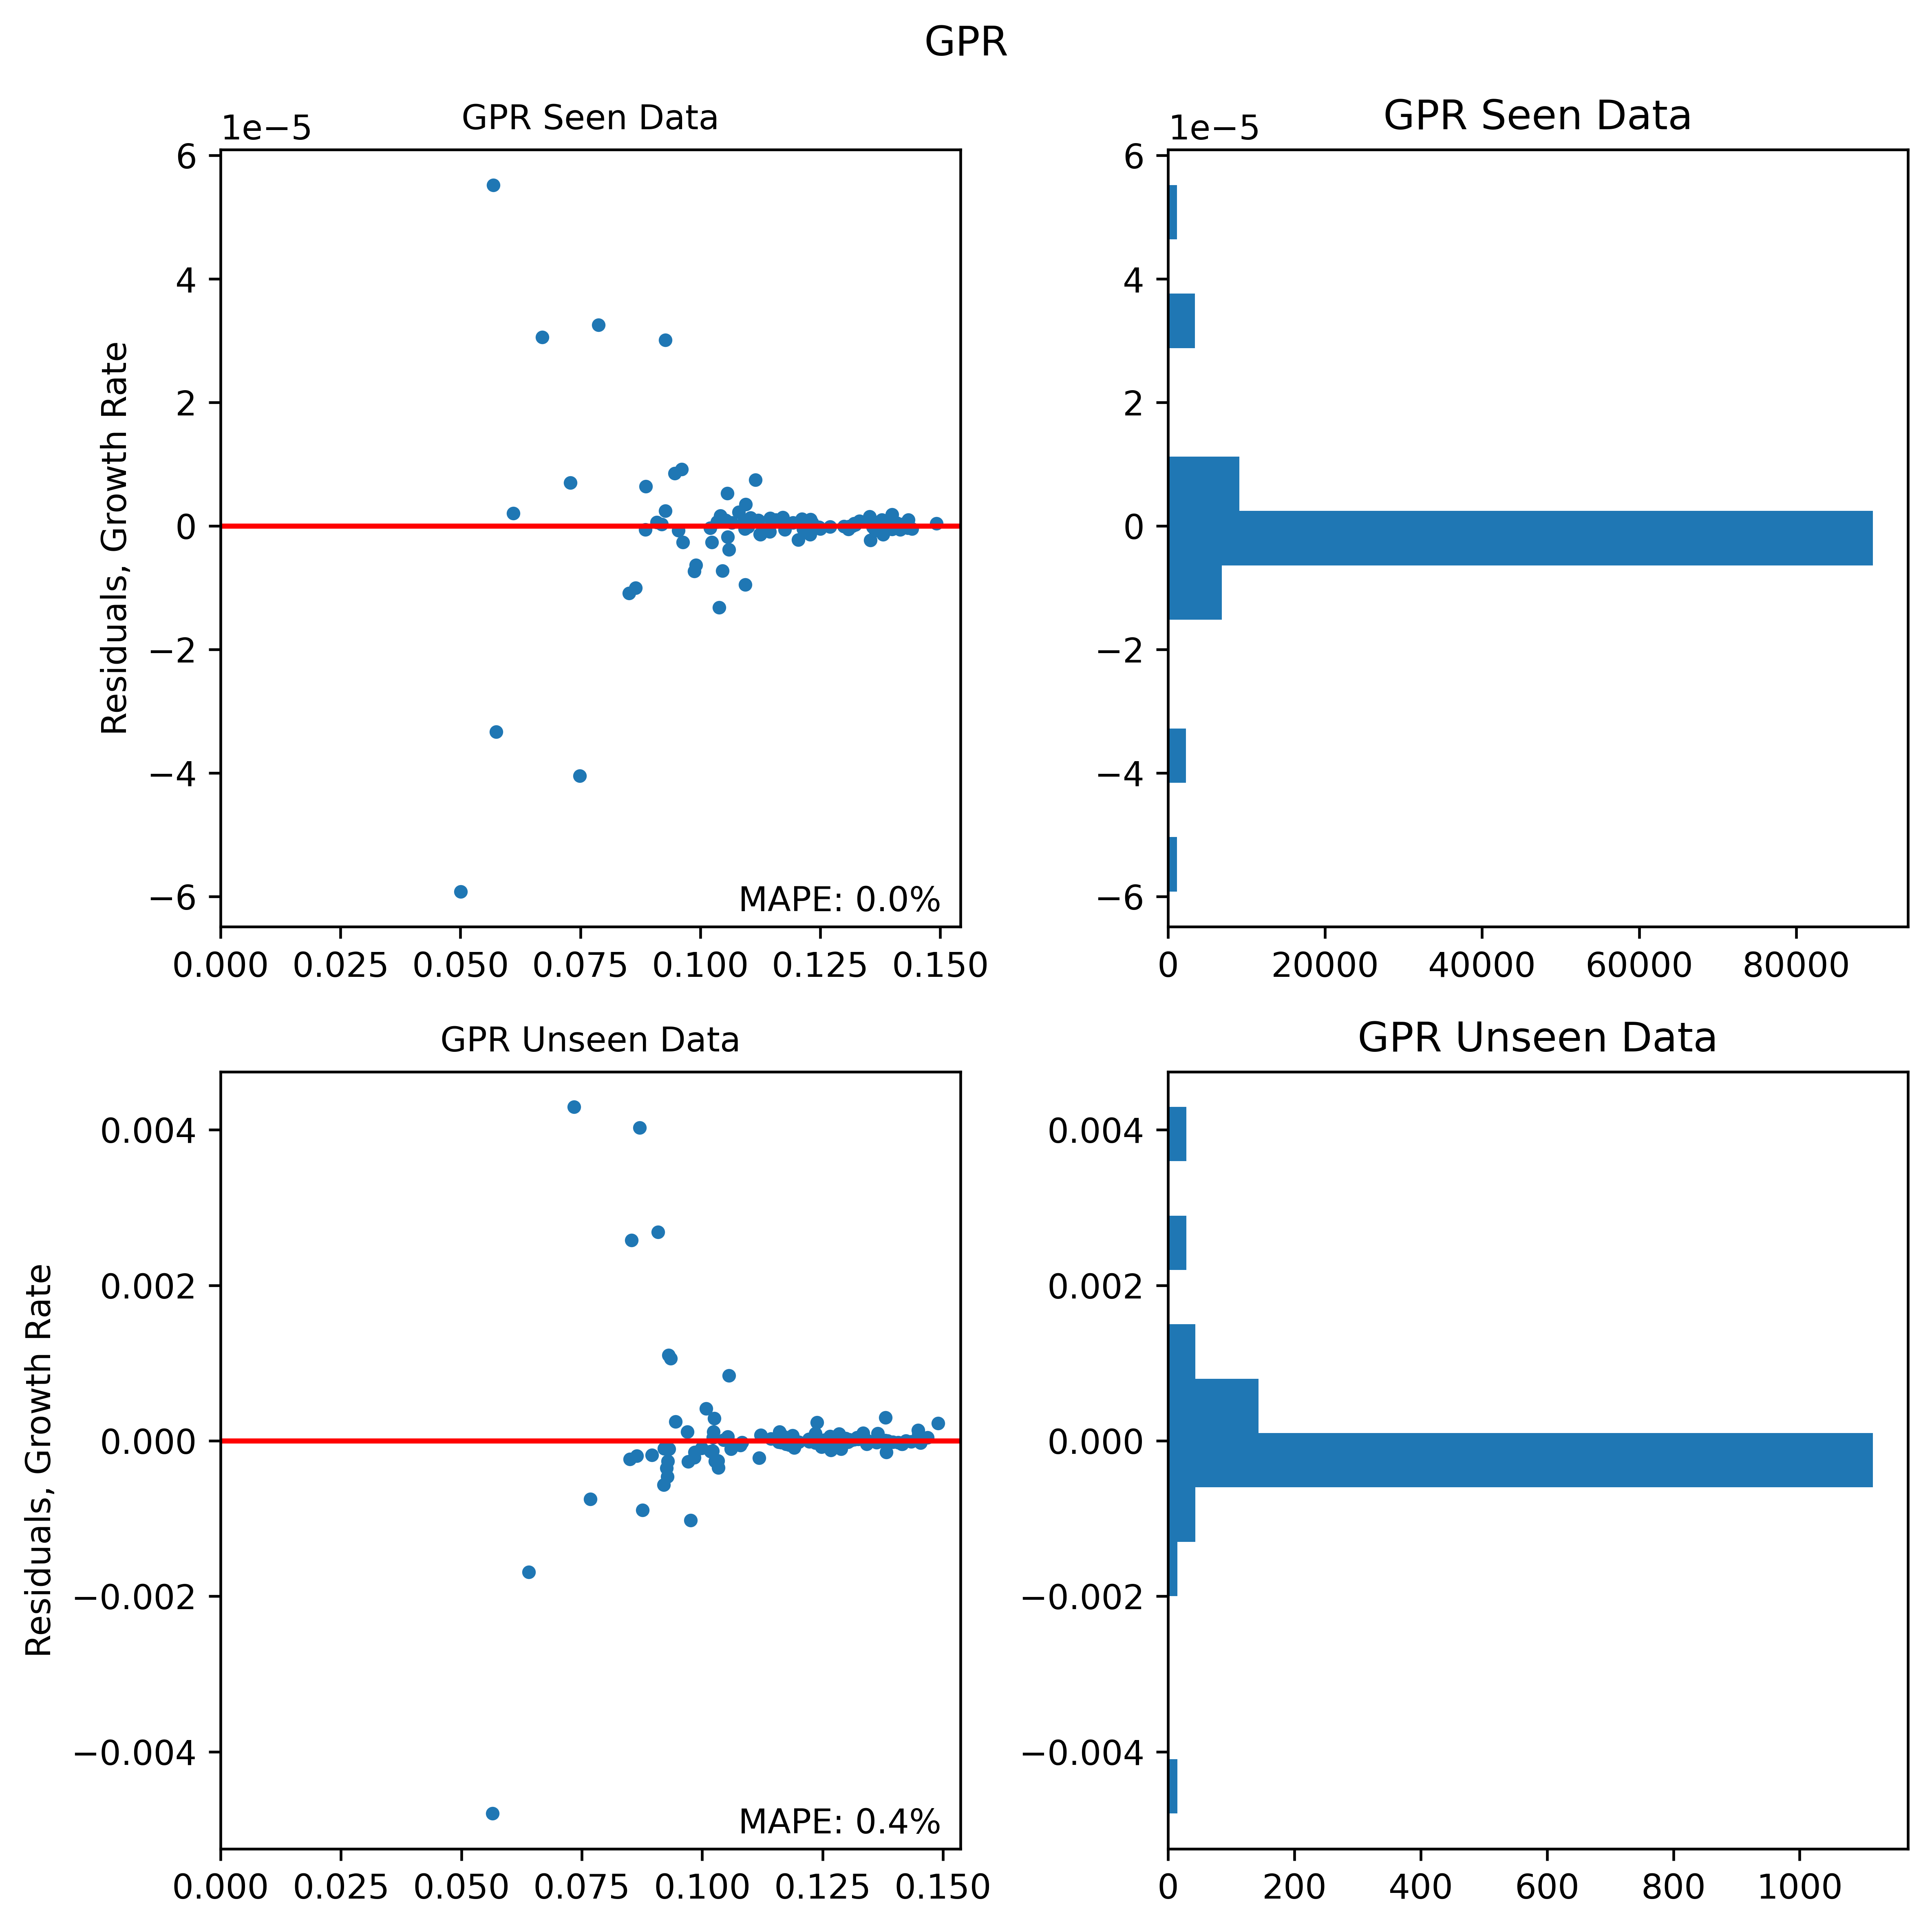

In [13]:
import matplotlib.pyplot as plt
from GENE_ML.gene_ml import visualise as vis

ncol=2
nrow=2
size=4
model_name = 'GPR'
fig_residuals, [[ax1,ax2],[ax3,ax4]] = plt.subplots(nrow,ncol, figsize=(size*ncol,size*nrow), dpi=600)
    
vis.residual_plot(ax1, fig_residuals, data_set_uniform.growthrate_train, results_gpr.growthrate_predict_seen, var_name='Growth Rate', title=f'{model_name} Seen Data')#, y_pred_err=growthrate_predict_seen_errors)
vis.residual_hist(ax2, fig_residuals, data_set_uniform.growthrate_train, results_gpr.growthrate_predict_seen, var_name='Growth Rate', title=f'{model_name} Seen Data', bins=13)

vis.residual_plot(ax3, fig_residuals, data_set_uniform.growthrate_test, results_gpr.growthrate_predict_unseen, var_name='Growth Rate', title=f'{model_name} Unseen Data')#, y_pred_err=growthrate_predict_unseen_errors)
vis.residual_hist(ax4, fig_residuals, data_set_uniform.growthrate_test, results_gpr.growthrate_predict_unseen, var_name='Growth Rate', title=f'{model_name} Unseen Data', bins=13)

# ax4.sharex(ax2)

fig_residuals.suptitle(model_name)
fig_residuals.tight_layout()
fig_residuals.show()

In [23]:
import numpy as np
from GENE_ML.gene_ml.samplers.gaussian import Gaussian

#swapped omts as they appeared in different order in dataset
bounds2 = [(2.1,3.5), (4,6.7), (0.16,2.9)] #if bounds is a float rather than tuple then the sampler will make that the only value
parameters2 = ['_grp_species_1-omt','_grp_species_0-omt','species-omn']
num_samples_g = 100000
gaussian = Gaussian(bounds2, num_samples_g, parameters2)
gaussian.samples_array

array([[2.51804697, 4.78538347, 1.15137538],
       [2.45458912, 5.49310162, 1.51219068],
       [2.91709763, 4.52863338, 3.24381748],
       ...,
       [2.66547217, 5.63319572, 1.72034748],
       [2.78275913, 4.52618974, 0.29039106],
       [2.37904285, 5.13477867, 0.62166332]])

In [22]:
print(gaussian.samples_array.shape)
print(data_set_uniform.x_train.shape)

print(gaussian.parameters)
print(data_set_uniform.df.head(1))



(100000, 3)
(100, 3)
['_grp_species_1-omt', '_grp_species_0-omt', 'species-omn']
   run_time      omt2      omt1      omn1 growthrate frequency
0       NaN  2.484996  4.499231  0.883268   0.099887  0.096284


[[2.518653 5.100391 1.474128]
 [2.763043 4.066328 2.867899]
 [2.594635 6.190552 1.927952]
 [2.35727  6.19004  1.175926]
 [2.877786 6.528088 2.870832]
 [2.225807 6.352249 2.179674]
 [2.982421 4.919742 1.568558]
 [3.17311  6.183974 2.193758]
 [2.520831 5.650782 1.419675]
 [3.401566 6.317828 2.128638]]
[0.114513 0.056868 0.136432 0.137804 0.130828 0.136128 0.111074 0.135426
 0.127031 0.139953]
SHAPE (1, 3) (100, 3)


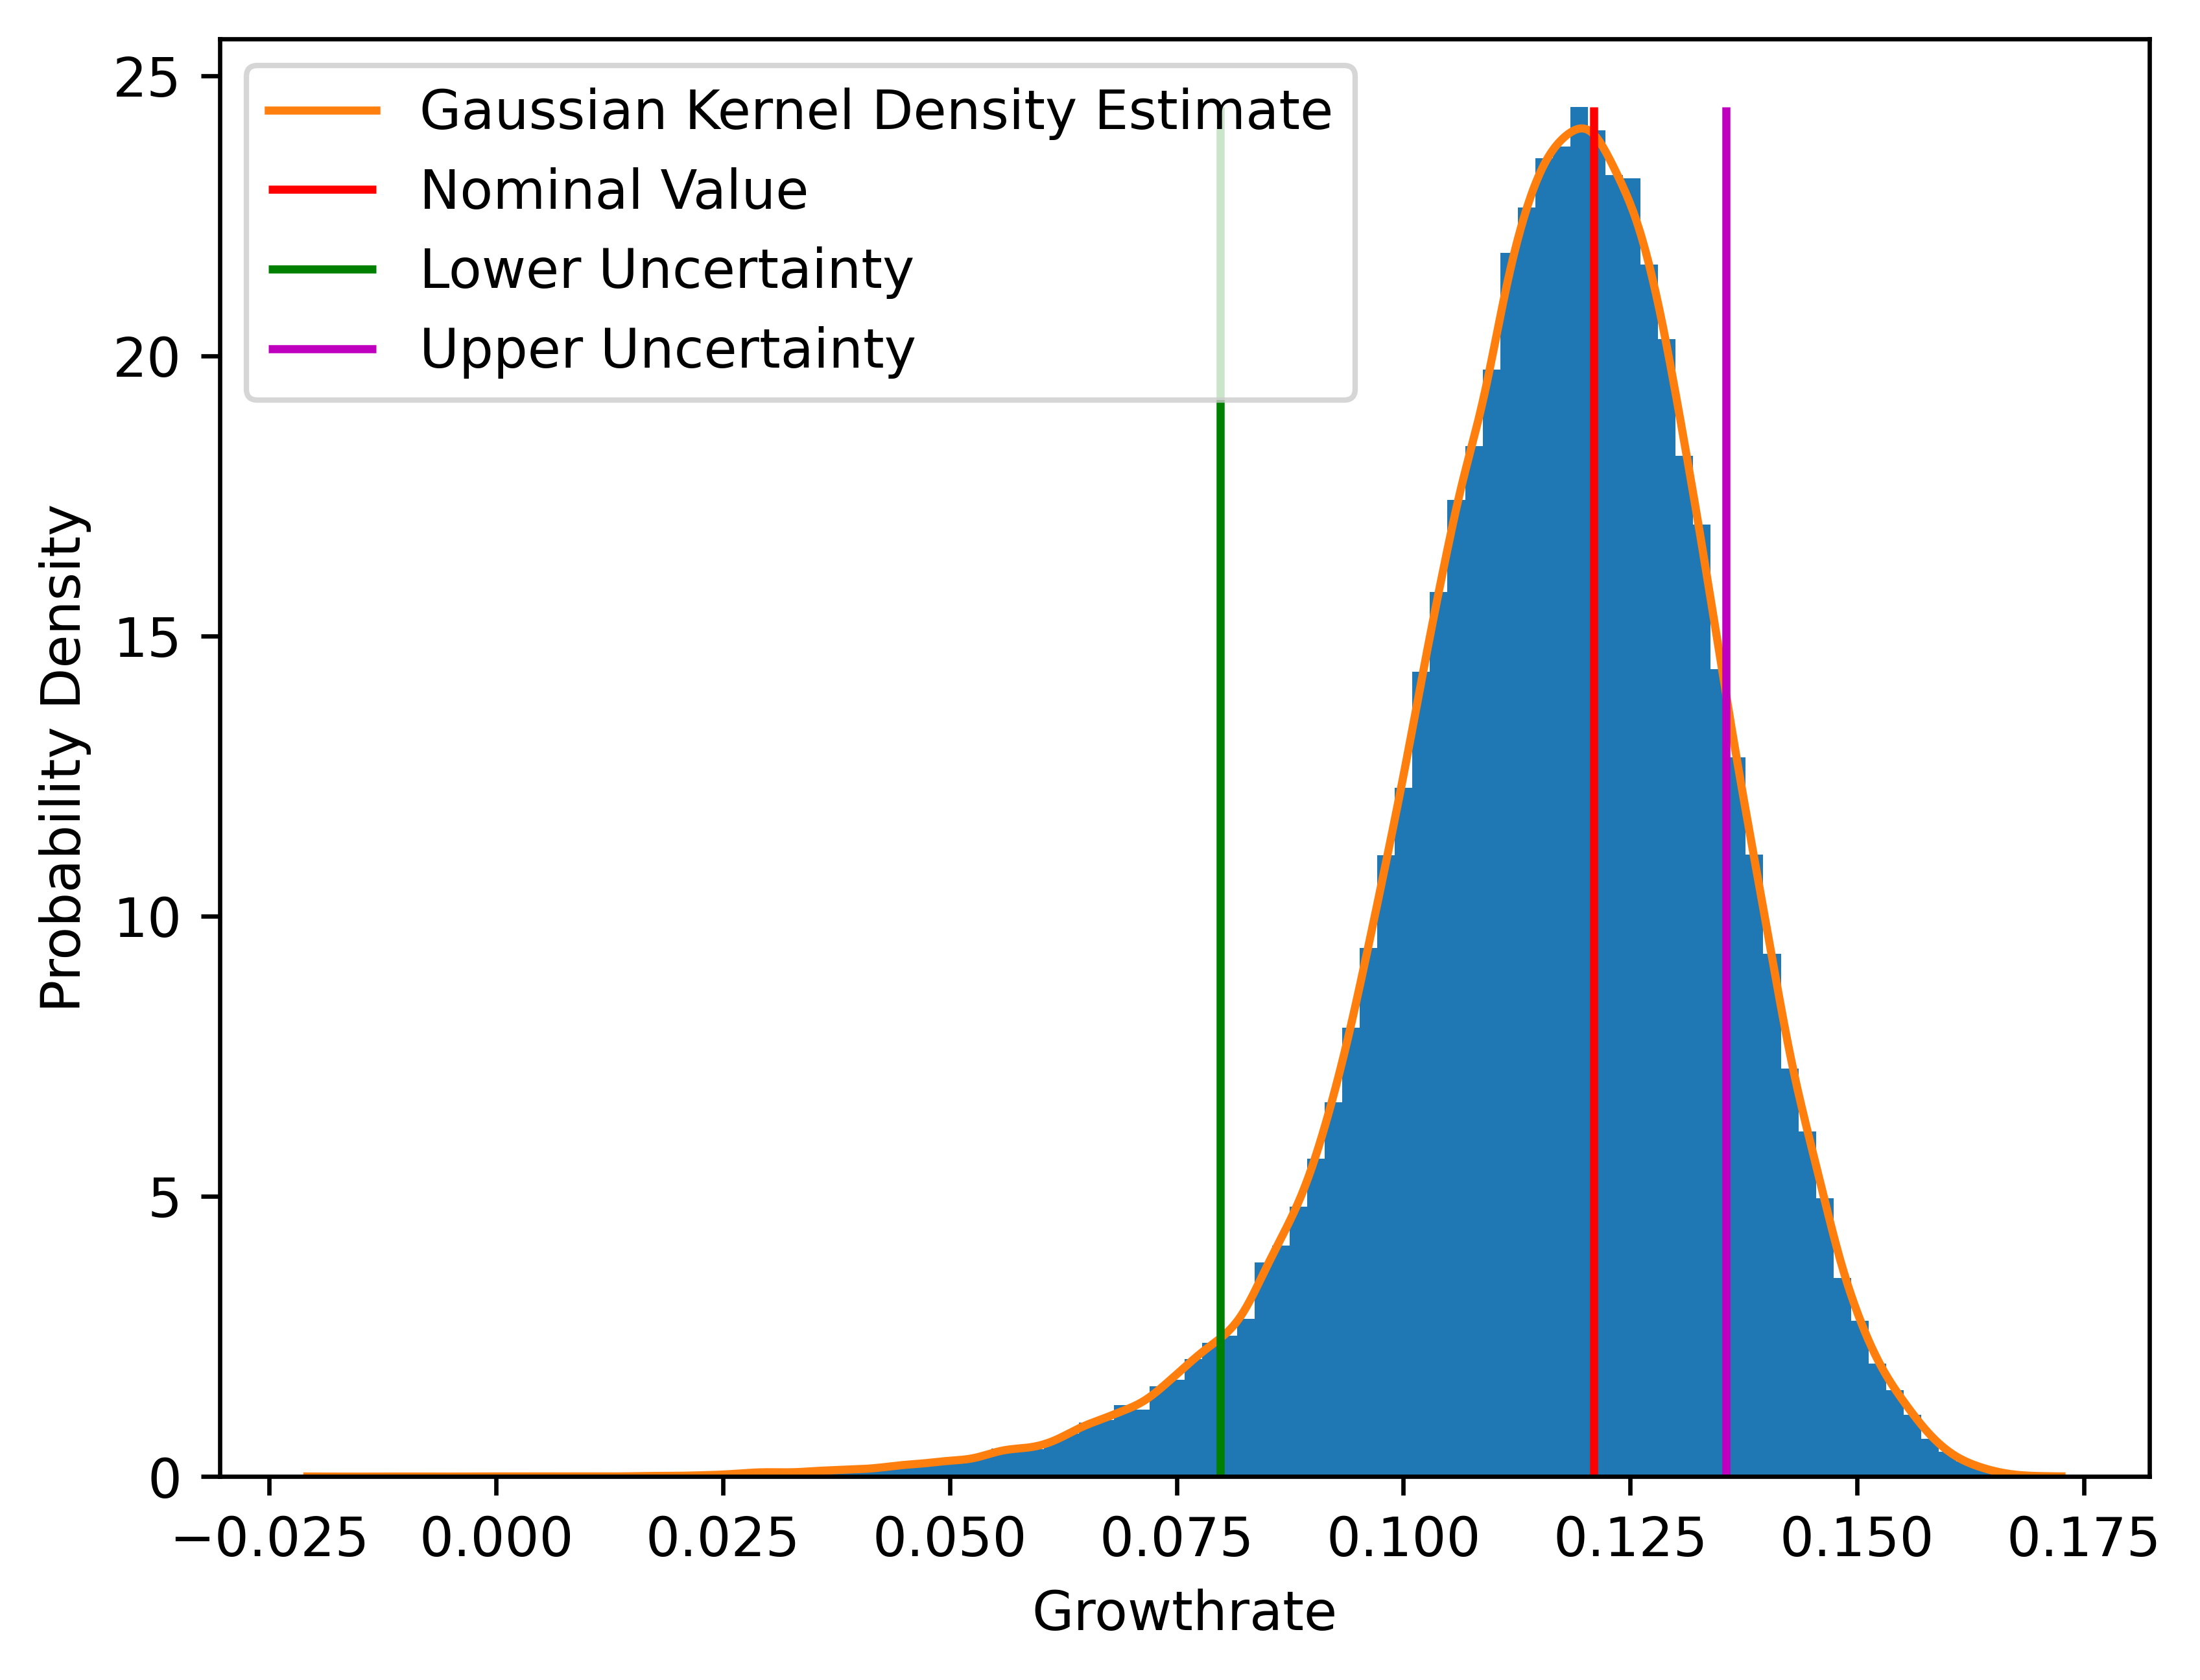

In [24]:
from scipy import stats
growthrates, _ = gpr.predict(gaussian.samples_array)
print(data_set_uniform.x_train[0:10])
print(data_set_uniform.growthrate_train[0:10])

nominal_parameters = np.array([np.mean(b) for b in bounds2]).reshape((len(bounds2),1)).T
print('SHAPE', nominal_parameters.shape, data_set_uniform.x_train.shape)
nominal_growthrate, _ = gpr.predict(nominal_parameters)
left_bound_gr, _ = gpr.predict(np.array([b[0] for b in bounds2]).reshape(len(bounds2),1).T)
right_bound_gr, _ = gpr.predict(np.array([b[1] for b in bounds2]).reshape(len(bounds2),1).T)

fig = plt.figure(dpi=600)
kde = stats.gaussian_kde(growthrates)
hist_x = np.linspace(np.min(growthrates),np.max(growthrates), 1000)
n, bins, _ = plt.hist(growthrates, bins=100, density=True)
plt.plot(hist_x, kde(hist_x), label='Gaussian Kernel Density Estimate')
plt.xlabel('Growthrate')
plt.ylabel('Probability Density')
plt.vlines(nominal_growthrate, 0, max(n), 'r', label='Nominal Value')
plt.vlines(left_bound_gr, 0, max(n), 'g', label='Lower Uncertainty')
plt.vlines(right_bound_gr, 0, max(n), 'm', label='Upper Uncertainty')
# plt.annotate(fr'$\nabla T_e$: {nominal_parameters[0][0]}$\pm$1.35  -  $\nabla T_i$: {nominal_parameters[0][1]}$\pm$0.7  -  Gaussian Error 95% Confidance',
            # xy=(0, 1.01), xycoords='axes fraction',fontsize=10)

plt.legend()
plt.show()


In [24]:
import numpy as np
from GENE_ML.gene_ml.samplers.uniform import Uniform

num_samples_u = 100000
uniform = Uniform(bounds2, num_samples_u, parameters2)

uniform.samples_array.shape

(100000, 3)

[[2.518653 5.100391 1.474128]
 [2.763043 4.066328 2.867899]
 [2.594635 6.190552 1.927952]
 [2.35727  6.19004  1.175926]
 [2.877786 6.528088 2.870832]
 [2.225807 6.352249 2.179674]
 [2.982421 4.919742 1.568558]
 [3.17311  6.183974 2.193758]
 [2.520831 5.650782 1.419675]
 [3.401566 6.317828 2.128638]]
[0.114513 0.056868 0.136432 0.137804 0.130828 0.136128 0.111074 0.135426
 0.127031 0.139953]
SHAPE (1, 3) (100, 3)


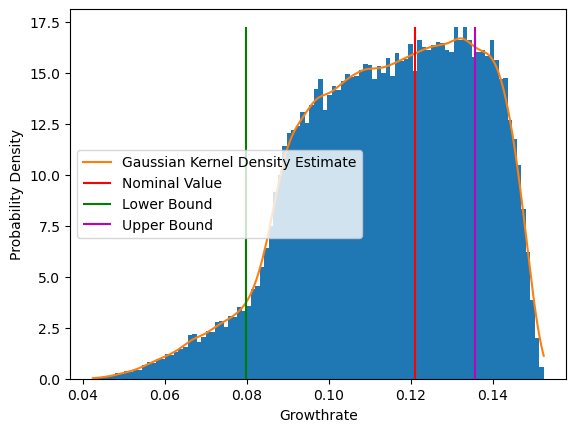

In [58]:
from scipy import stats
growthrates, _ = gpr.predict(uniform.samples_array)
print(data_set_uniform.x_train[0:10])
print(data_set_uniform.growthrate_train[0:10])

nominal_parameters = np.array([np.mean(b) for b in bounds2]).reshape((len(bounds2),1)).T
print('SHAPE', nominal_parameters.shape, data_set_uniform.x_train.shape)
nominal_growthrate, _ = gpr.predict(nominal_parameters)
left_bound_gr, _ = gpr.predict(np.array([b[0] for b in bounds2]).reshape(len(bounds2),1).T)
right_bound_gr, _ = gpr.predict(np.array([b[1] for b in bounds2]).reshape(len(bounds2),1).T)

kde = stats.gaussian_kde(growthrates)
hist_x = np.linspace(np.min(growthrates),np.max(growthrates), 1000)
n, bins, _ = plt.hist(growthrates, bins=100, density=True)
plt.plot(hist_x, kde(hist_x), label='Gaussian Kernel Density Estimate')
plt.xlabel('Growthrate')
plt.ylabel('Probability Density')
plt.vlines(nominal_growthrate, 0, max(n), 'r', label='Nominal Value')
plt.vlines(left_bound_gr, 0, max(n), 'g', label='Lower Bound')
plt.vlines(right_bound_gr, 0, max(n), 'm', label='Upper Bound')
# plt.annotate(f'ETG: {nominal_parameters[0][0]}$\pm$1.35  -  ITG: {nominal_parameters[0][1]}$\pm$0.7  -  Bounded Uniform Error',
#             xy=(0, 1.01), xycoords='axes fraction',fontsize=10)

plt.legend()
plt.show()



In [6]:
#allows any changes on external files to be loaded on code run.
%load_ext autoreload
%autoreload 2

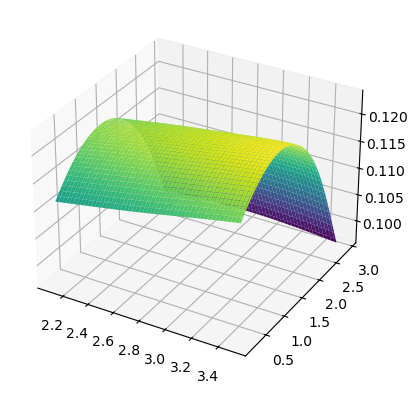

In [7]:
import numpy as np
import matplotlib.pyplot as plt
def plot_2D_of_many(function, bounds, nominals, which2 = [1,2], grid_size=100):
    extra=0
    xlow, xhigh = bounds[which2[0]][0]-extra, bounds[which2[0]][1]+extra
    ylow, yhigh = bounds[which2[1]][0]-extra, bounds[which2[1]][1]+extra
    x = np.linspace(xlow, xhigh, grid_size)
    y = np.linspace(ylow, yhigh, grid_size)
    X, Y = np.meshgrid(x, y)
    
    arrays2stack = []
    for i, n in enumerate(nominals):
        arrays2stack.append(np.full_like(X,n))
    arrays2stack[which2[0]] = X
    arrays2stack[which2[1]] = Y
    pos = np.dstack(arrays2stack)
    
    # print(pos.shape)
    Z = np.zeros(shape=(grid_size,grid_size))
    pos_flat = pos.flatten()
    for i in range(grid_size):
        for j in range(grid_size):
            p = nominals
            p[which2[0]] = X[i,j]
            p[which2[1]] = Y[i,j]
            Z[i,j] = function(p)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
bounds2 = [(2.1,3.5), (4,6.7), (0.16,2.9)]
nominal_parameters = np.array([np.mean(b) for b in bounds2]).reshape((len(bounds2),1)).T
function = lambda X: gpr.predict(X, disclude_errors=True)
plot_2D_of_many(function, bounds2, nominals = nominal_parameters[0], which2=[0,2])




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


change swap2


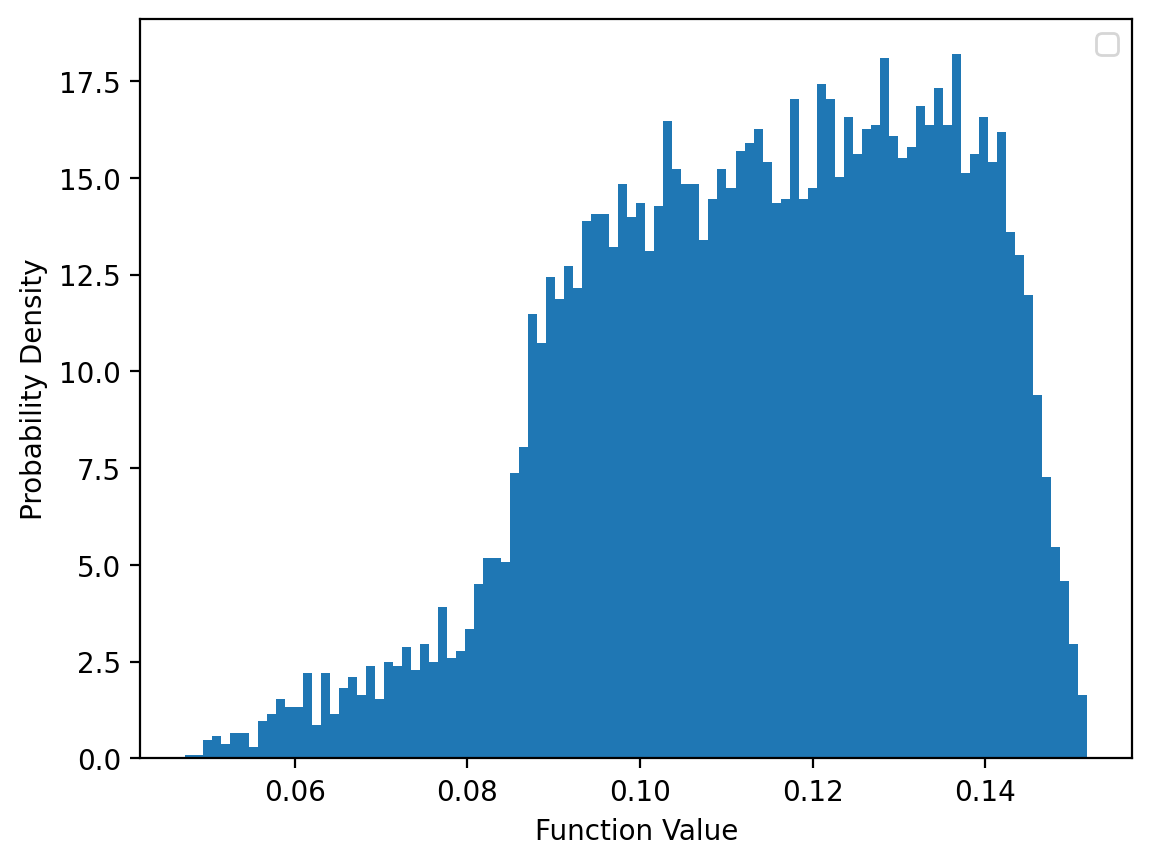

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


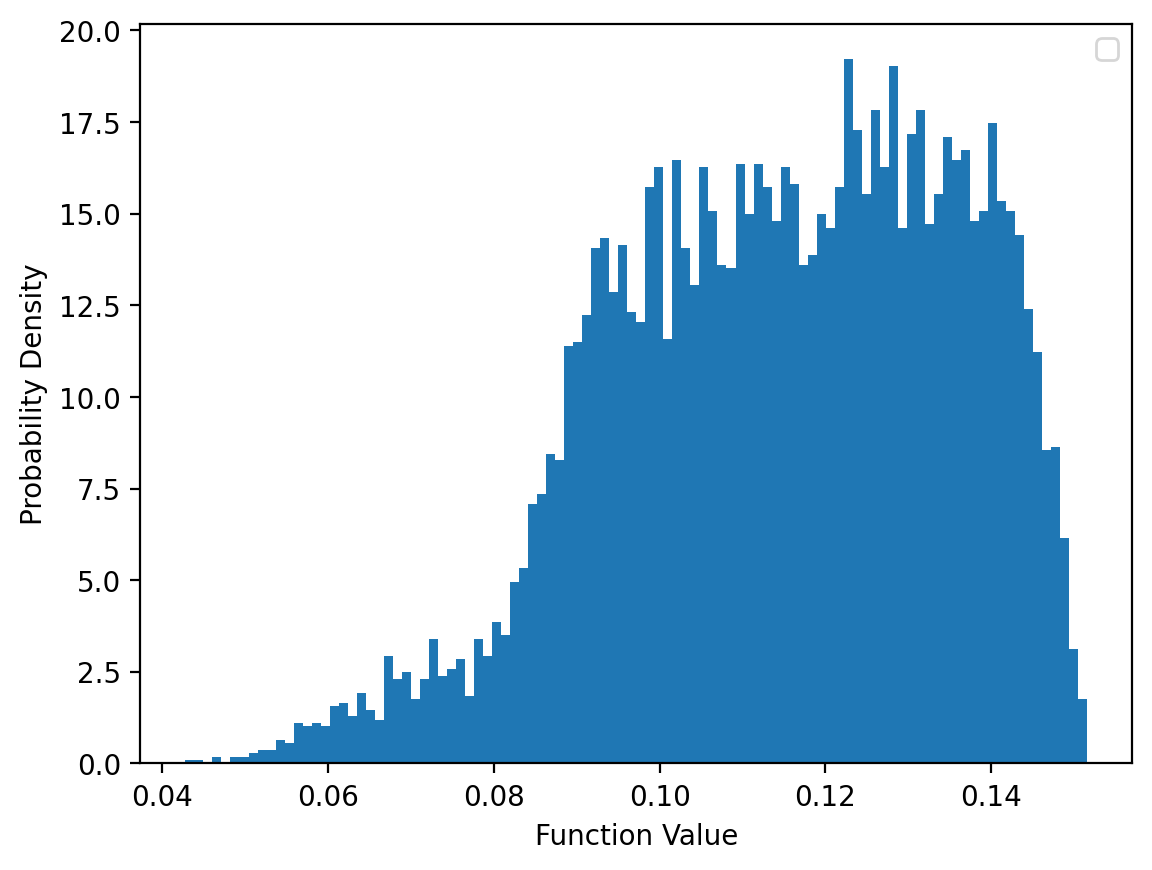

In [20]:
from GENE_ML.gene_ml.uncertianty_quantification.montecarlo import Montecarlo
fun = lambda X:(gpr.predict(X, disclude_errors=True))
mc = Montecarlo(function=fun)
mc.uniform_uq3(bounds=bounds2, num_samples=10**4, num_bins=100)